## Plot the Mean & Standard Deviation of The Fetal and Total Pathlength Per SDD

In [2]:
# Import Pathlength Files

from pathlib import Path
from glob import glob
import pandas as pd
import json
from inverse_modelling_tfo.data.generate_intensity import create_sdd_column
import matplotlib.pyplot as plt
import seaborn as sns

raw_file_path = Path(r'/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2')

raw_files = list(raw_file_path.glob("*.pkl"))  # RAW files are in pickle format
raw_files = [Path(file) for file in raw_files]

file1 = raw_files[0]
config1 = file1.with_suffix('.json')
raw_data1 = pd.read_pickle(file1)
with open(config1) as f:
    config_data1 = json.load(f)


all_ppath_columns = list(filter(lambda x: 'ppath' in x, raw_data1.columns))
raw_data1['Total ppath'] = raw_data1[all_ppath_columns].sum(axis=1)


raw_data1 = create_sdd_column(raw_data1)
all_sdd = raw_data1['SDD'].unique()
all_sdd.sort()
print(all_sdd)

[10 15 19 24 28 33 37 41 46 50 55 59 64 68 72 77 81 86 90 94]


## Ridge Plots

In [3]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


# selected_sdd = all_sdd[:5]

# ridge_data = raw_data1[['L4 ppath', 'SDD', 'Total ppath']]
# ridge_data = ridge_data[ridge_data['SDD'].isin(selected_sdd)]
# ridge_data = ridge_data[ridge_data['Total ppath'] < 1000]

# # Initialize the FacetGrid object
# pal = sns.cubehelix_palette(len(selected_sdd), rot=-.25, light=.7)
# g = sns.FacetGrid(ridge_data, row="SDD", hue="SDD", aspect=15, height=.5, palette=pal)

# # Draw the densities in a few steps
# g.map(sns.kdeplot, "Total ppath",
#       bw_adjust=.5, clip_on=False,
#       fill=True, alpha=1, linewidth=1.5)
# g.map(sns.kdeplot, "Total ppath", clip_on=False, color="w", lw=2, bw_adjust=.5)



# # passing color=None to refline() uses the hue mapping
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# # Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color,
#             ha="left", va="center", transform=ax.transAxes)

# g.map(label, "L4 ppath")

# # Set the subplots to overlap
# g.figure.subplots_adjust(hspace=-.25)


# # Remove axes details that don't play well with overlap
# g.set_titles("")
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)
# # g.set(yscale="log")

## Individual Bar Plots

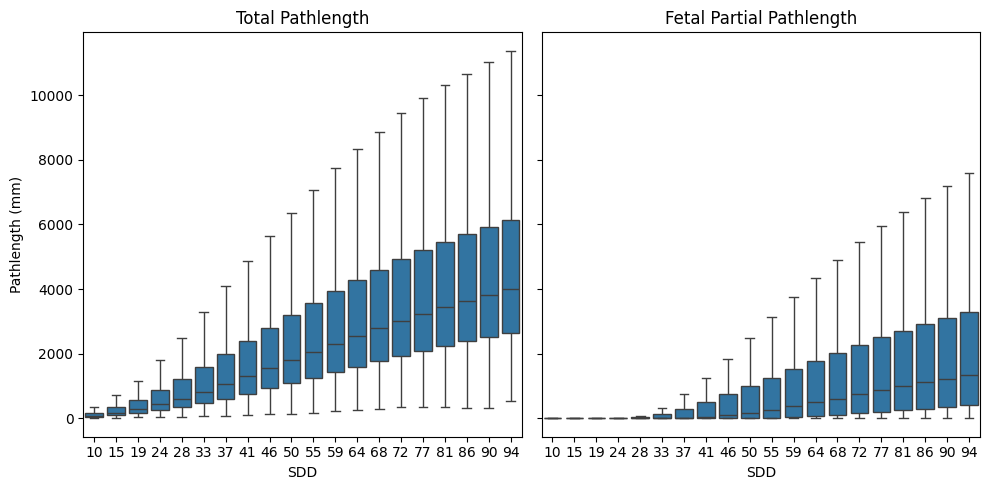

In [4]:
# Plot the Median of Total Pathlength and L4 Pathlength for each SDD
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.boxplot(x='SDD', y='Total ppath', data=raw_data1, ax=ax[0], showfliers=False)
sns.boxplot(x='SDD', y='L4 ppath', data=raw_data1, ax=ax[1], showfliers=False)
ax[0].set_title('Total Pathlength')
ax[1].set_title('Fetal Partial Pathlength')
# Remove the y-axis label from the right plot
ax[1].set_ylabel('')
ax[0].set_ylabel('Pathlength (mm)')
plt.tight_layout()
plt.show()

# Side By Side Bar Plot

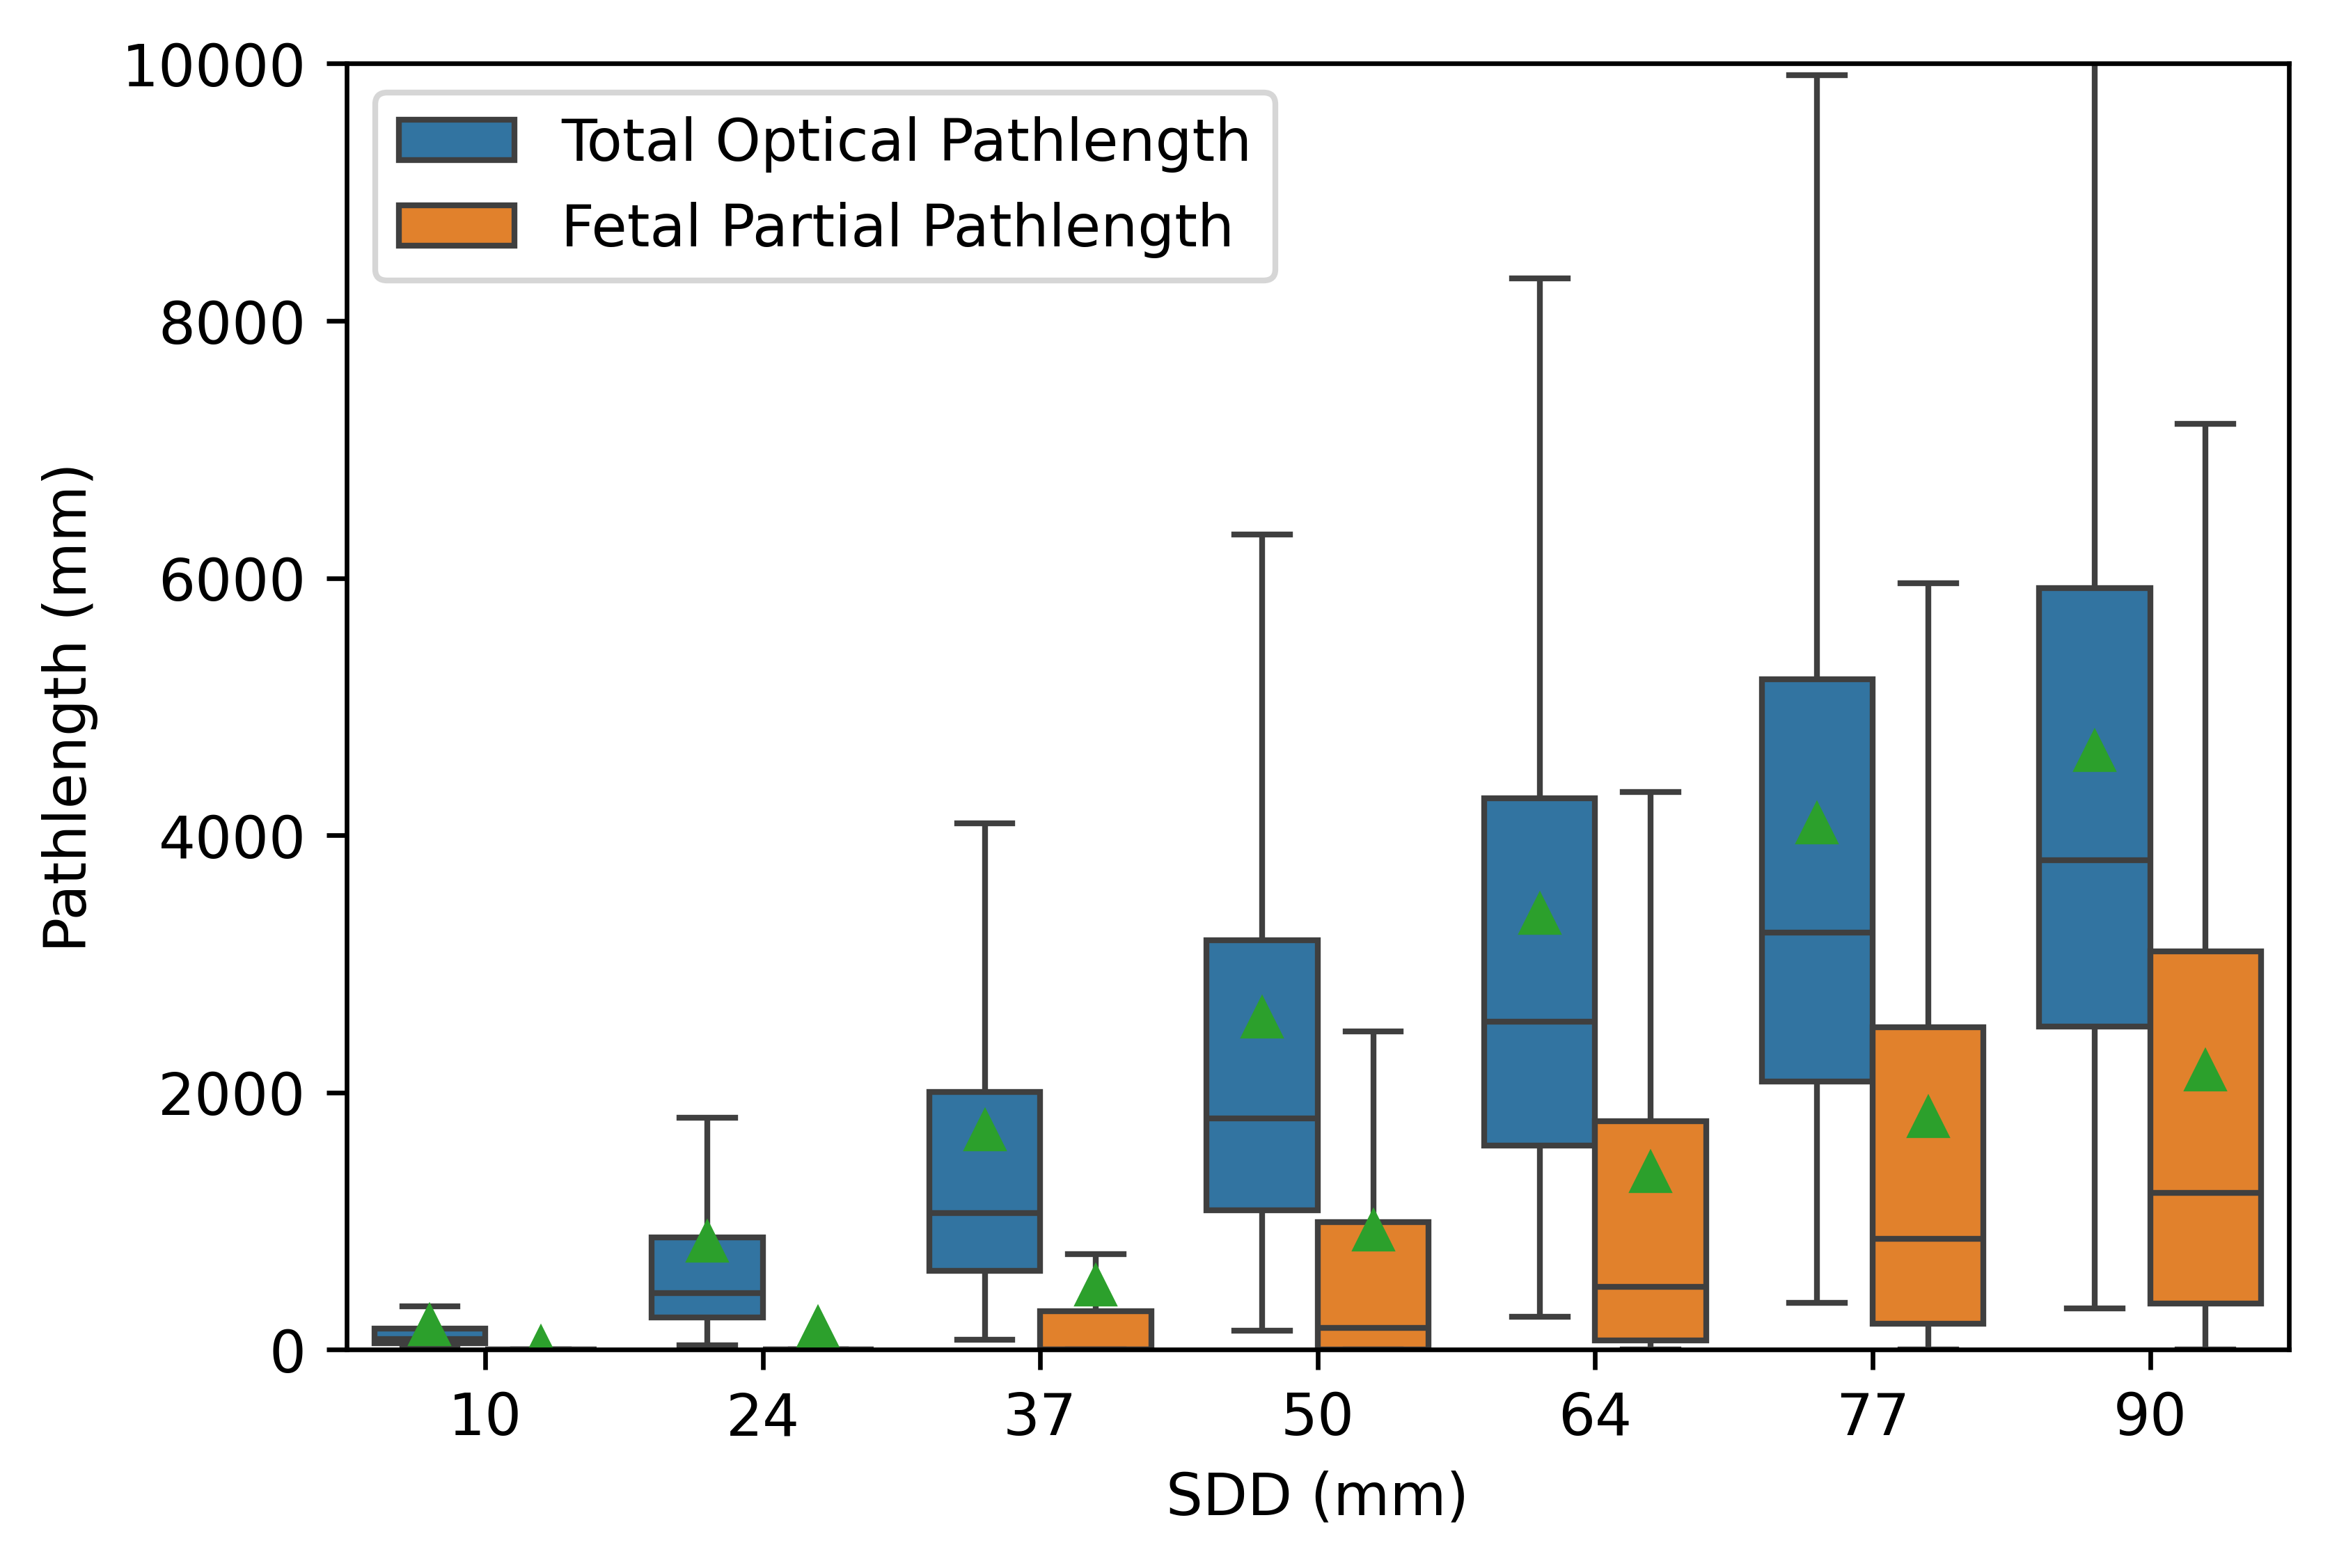

In [5]:
plt.figure(figsize=(6, 4), dpi=600)
chosen_sdd = all_sdd[::3]
wide_frmt = raw_data1[raw_data1['SDD'].isin(chosen_sdd)]
# Rename Columns for better visualization
wide_frmt = wide_frmt.rename(columns={'Total ppath': 'Total Optical Pathlength',  'L1 ppath': 'Maternal Partial Pathlength', 'L4 ppath': 'Fetal Partial Pathlength'})
# wide_frmt = wide_frmt.melt(id_vars=['SDD'], value_vars=['Total Optical Pathlength', 'Maternal Partial Pathlength', 'Fetal Partial Pathlength'], var_name='Type', value_name='Length (mm)')
wide_frmt = wide_frmt.melt(id_vars=['SDD'], value_vars=['Total Optical Pathlength', 'Fetal Partial Pathlength'], var_name='Type', value_name='Length (mm)')
sns.boxplot(x='SDD', y='Length (mm)', hue='Type', data=wide_frmt, showfliers=False, legend=True, showmeans=True)
plt.legend(loc='upper left')
plt.ylim(0, 10000)
plt.xlabel('SDD (mm)')
plt.ylabel('Pathlength (mm)')
plt.savefig('saved_figures/boxplot_pathlength_vs_sdd.svg')

# Sensitivity
Defined as 
$$
S = \frac{\delta Signal}{\mu_{a, f}} / (\frac{\delta Signal}{\mu_{a, f}} + \frac{\delta Signal}{\mu_{a, m}})
$$
The above term simplifies to M5 from this paper (https://opg.optica.org/boe/fulltext.cfm?uri=boe-14-11-6031&id=541261)

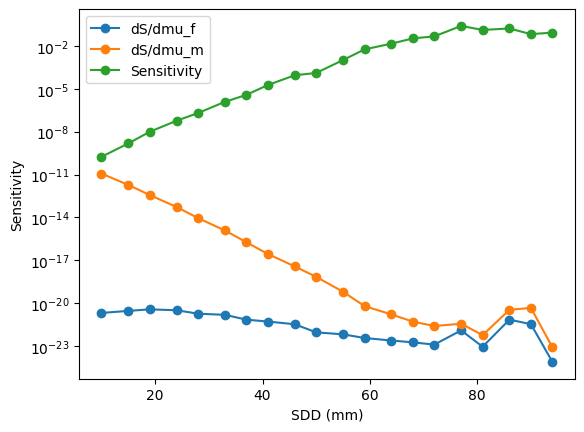

In [6]:
from inverse_modelling_tfo.data.generate_intensity import create_intensity_column
from inverse_modelling_tfo.data.intensity_normalization import config_based_normalization
from tfo_sim.model_creation.models import DanModel4LayerX
from tfo_sim.model_creation import SimulationParameters

# Create mu_map using the tissue model
sim_params = SimulationParameters(wavelength=config_data1['wavelength'])
tissue_model = DanModel4LayerX(sim_params)
props = tissue_model.get_optical_properties()
mu_a = [layer['mua'] for layer in props]
mu_a = mu_a[1:]     # Drop Air layer
mu_map = {i + 1: mu_a[i] for i in range(len(mu_a))}     # Layer Index starts from 1

# Create Intensity Column
raw_data1 = create_intensity_column(raw_data1, mu_map)
config_based_normalization(raw_data1, config1)

# Calculate del Signal del mu_f
dS_dmu_f = (raw_data1['L4 ppath'] * raw_data1['Intensity']).groupby(raw_data1['SDD']).mean()
dS_dmu_m = (raw_data1['L1 ppath'] * raw_data1['Intensity']).groupby(raw_data1['SDD']).mean()
sensitivity = dS_dmu_f / (dS_dmu_f + dS_dmu_m)

plt.plot(dS_dmu_f, marker='o', label='dS/dmu_f')
plt.plot(dS_dmu_m, marker='o', label='dS/dmu_m')
plt.plot(sensitivity, marker='o', label='Sensitivity')
plt.xlabel('SDD (mm)')
plt.legend()
plt.ylabel('Sensitivity')
plt.yscale('log')

# Pathlength Dsitribution at Fixed Detector for different Fetal Depths
(This part is independent of the rest of code. Just run these cells if you only need this plot)

In [7]:
from pathlib import Path
from glob import glob
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load files
# Get all the raw files
raw_file_path = Path(r'/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2')
raw_files = list(raw_file_path.glob("*.pkl"))  # RAW files are in pickle format
raw_files = [Path(file) for file in raw_files]

# Filter
chosen_wall_thicknesses = [4, 14, 24]
chosen_sdd = 50.
chosen_wavelength = 735
chosen_files = list(filter(lambda x: int(x.stem.split('_')[-1]) in chosen_wall_thicknesses, raw_files))
chosen_files = list(filter(lambda x: int(x.stem.split('_')[-3]) == chosen_wavelength, chosen_files))
config_files = [x.with_suffix('.json') for x in chosen_files]
print(chosen_files)

[PosixPath('/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2/dan_iccps_pencil_wave_735_dermis_24.pkl'), PosixPath('/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2/dan_iccps_pencil_wave_735_dermis_14.pkl'), PosixPath('/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2/dan_iccps_pencil_wave_735_dermis_4.pkl')]


In [8]:
merged_df = pd.DataFrame(columns=['SDD', 'Fetal Depth', 'Total Path', 'Maternal Partial Pathlength', 'Fetal Partial Path'])
for file in chosen_files:
    # Load file and config
    config_file = file.with_suffix('.json')
    raw_data = pd.read_pickle(file)
    with open(config_file) as f:
        config_data = json.load(f)
    raw_data = create_sdd_column(raw_data)
    raw_data = raw_data[raw_data['SDD'] == chosen_sdd]
    
    # Get total path
    all_ppath_columns = list(filter(lambda x: 'ppath' in x, raw_data.columns))
    raw_data['Total Path'] = raw_data[all_ppath_columns].sum(axis=1)
    raw_data['Fetal Depth'] = config_data['dermis_thickness'] + 6
    
    # Concatenate
    df_to_concat = raw_data[['SDD', 'Fetal Depth', 'Total Path', 'L1 ppath', 'L4 ppath']]
    df_to_concat = df_to_concat.rename(columns={'L1 ppath' : 'Maternal Partial Pathlength', 'L4 ppath': 'Fetal Partial Path'})
    merged_df = pd.concat([merged_df, df_to_concat])

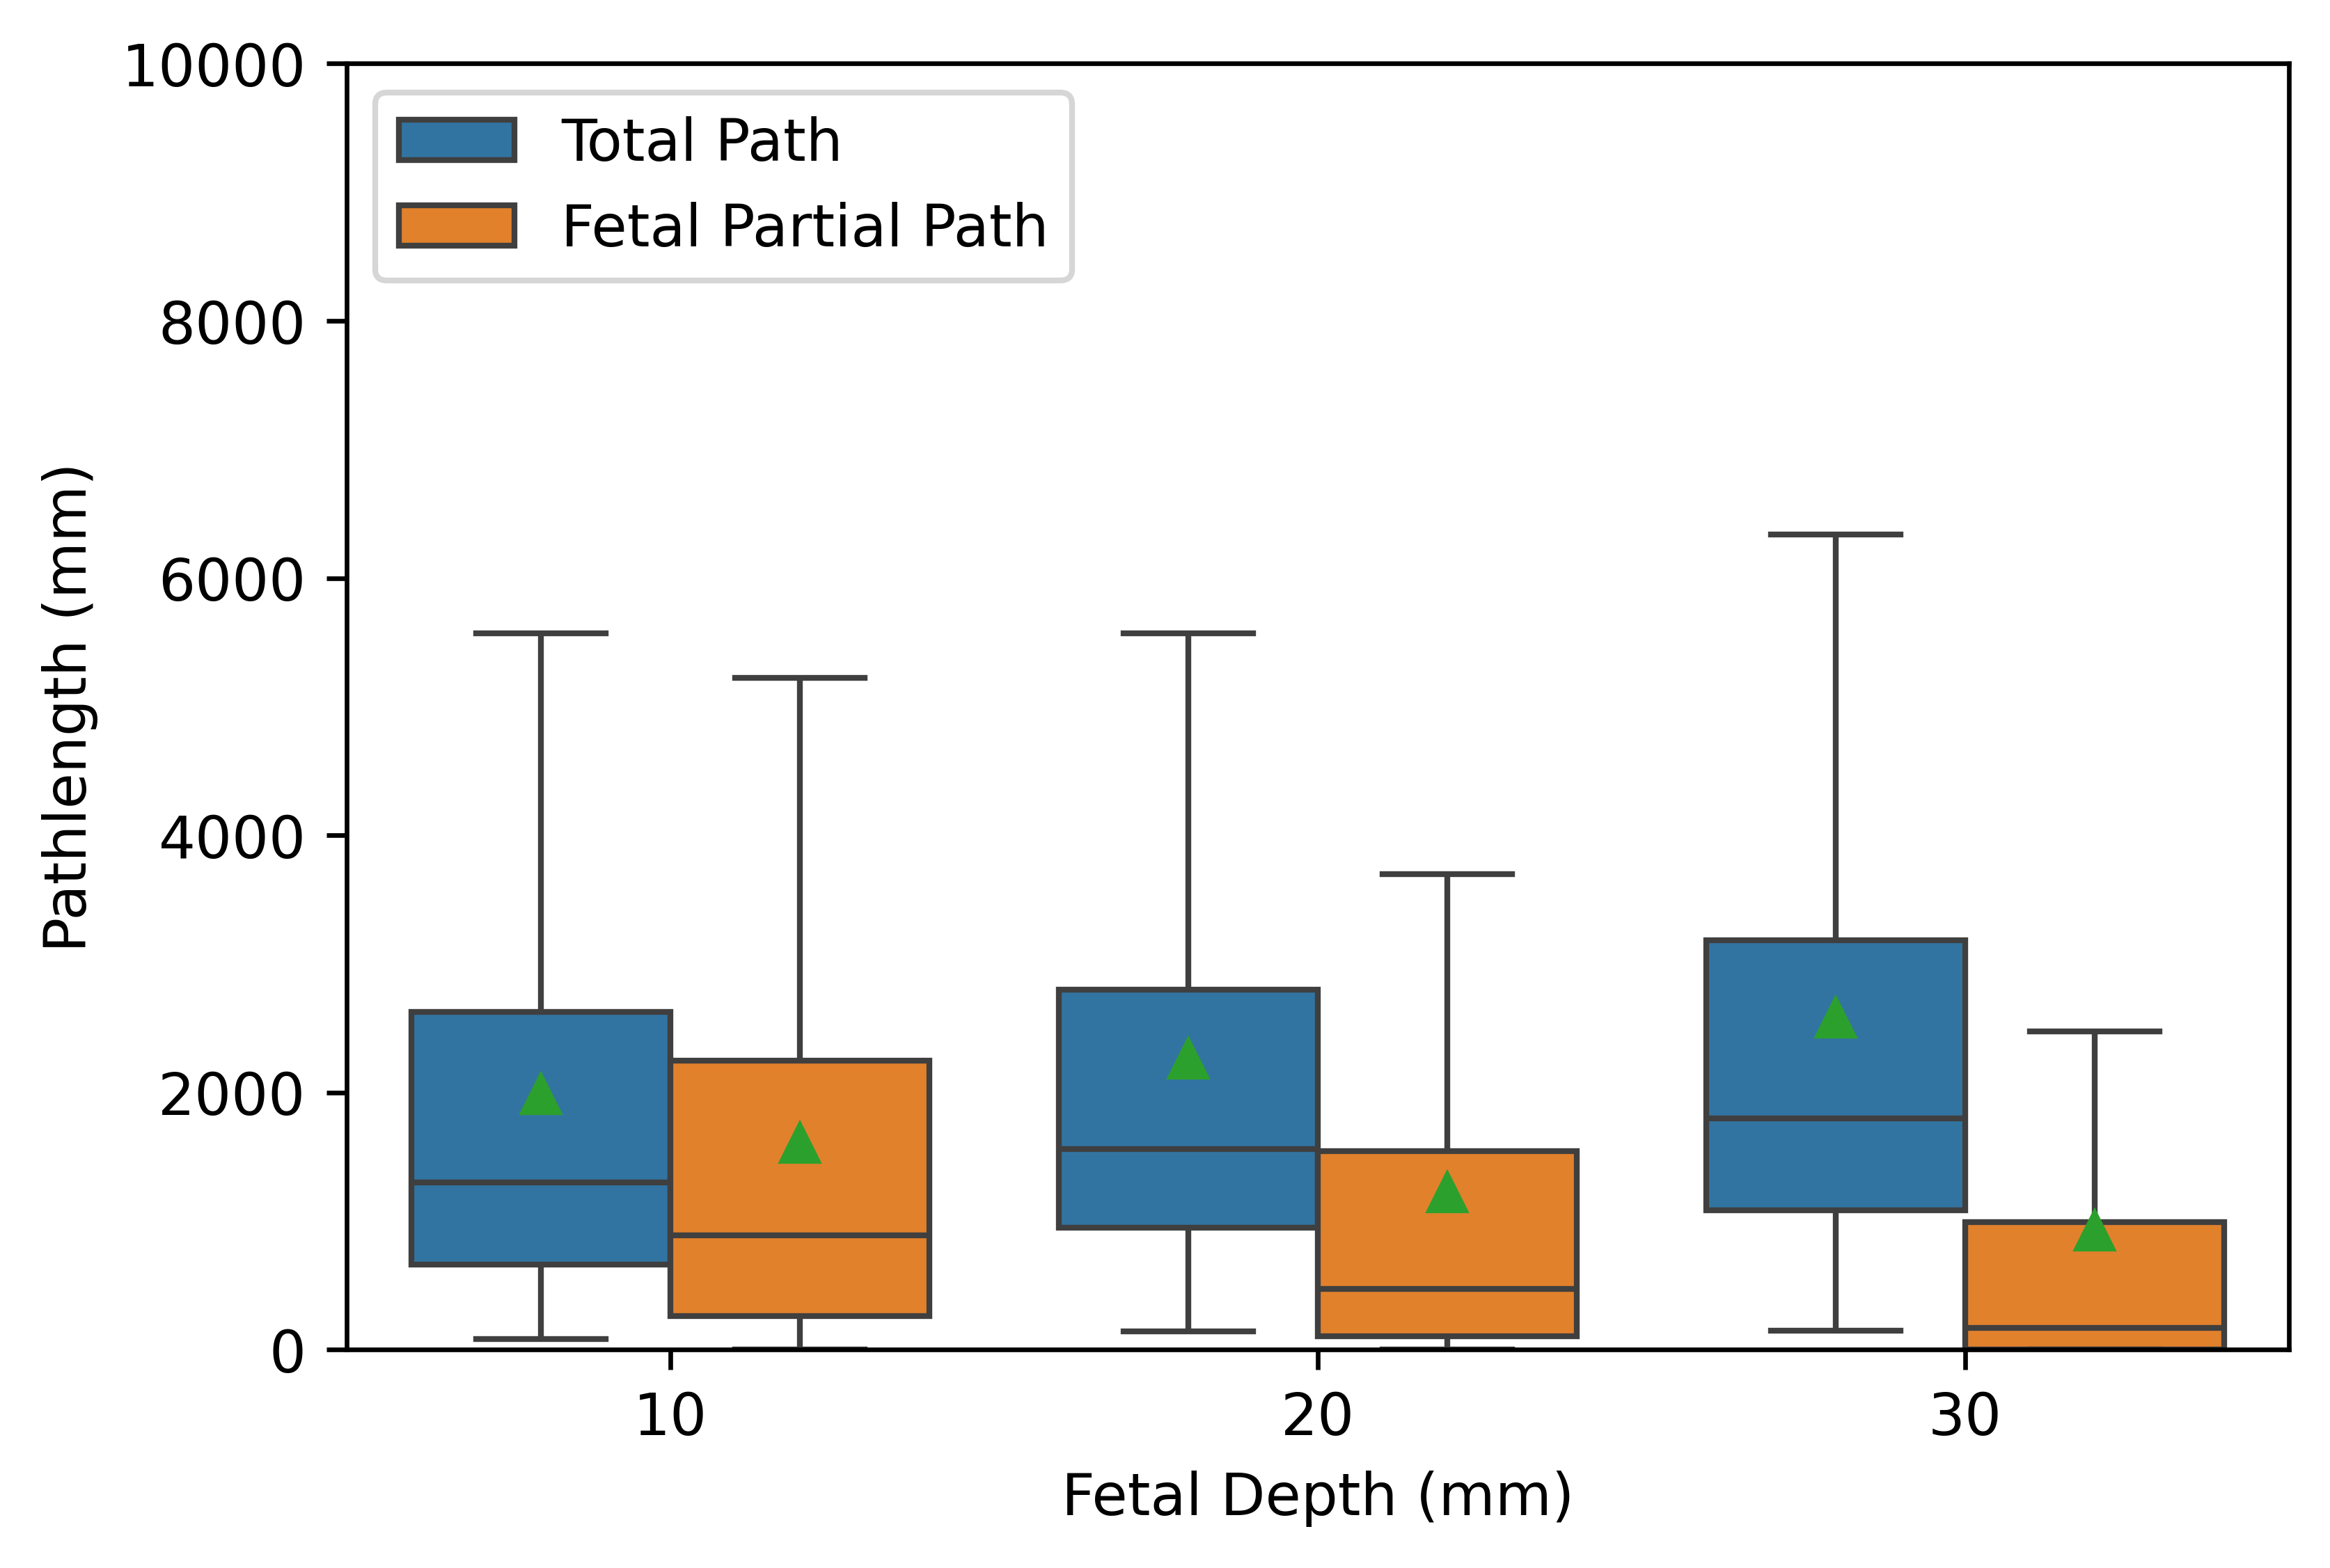

In [9]:
plt.figure(figsize=(6, 4), dpi=600)
merged_df_to_plot = merged_df.melt(id_vars=['SDD', 'Fetal Depth'], value_vars=['Total Path', 'Fetal Partial Path'], var_name='Type', value_name='Length (mm)')
# merged_df_to_plot = merged_df.melt(id_vars=['SDD', 'Fetal Depth'], value_vars=['Total Path', 'Maternal Partial Pathlength', 'Fetal Partial Path'], var_name='Type', value_name='Length (mm)')
sns.boxplot(x='Fetal Depth', y='Length (mm)', hue='Type', data=merged_df_to_plot, showfliers=False, legend=True, showmeans=True)
plt.legend(loc='upper left')
plt.ylim(0, 10000)
plt.xlabel('Fetal Depth (mm)')
plt.ylabel('Pathlength (mm)')
plt.savefig('saved_figures/boxplot_pathlength_vs_fetal_depth.svg')